In [1]:
#All the imports
import time
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\18643\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#Record run time for code to decide on size of data set to use for analysis
StartTime = time.time()

In [3]:
#Reading in two very different data frames: Luxury Beauty and Video Games
#To help with intense computational requirements, limiting to approximately 100,000 reviews
LuxuryBeautyDF = pd.read_json('Luxury_Beauty.json', lines=True) # Read in json file as a dataframe
VideoGamesDF = pd.read_json('Video_Games_5.json', lines=True)
Blend = [LuxuryBeautyDF,VideoGamesDF]
BlendDF = pd.concat(Blend)
BlendDF = BlendDF.sample(frac = 0.10).reset_index() 

In [4]:
#Add column with Date from converted Unix time. Unfortunately results does not give time.
BlendDF["Date"] = pd.to_datetime(BlendDF["unixReviewTime"], unit='s')

In [5]:
#Create binary rating column: 0 (negative = 1-2), 1 (positive = 3-5)
#Binning decision came from running tests against validation data
conditions = [
    (BlendDF["overall"] > 2),
    (BlendDF["overall"] < 3)
    ]
values = [1, 0]
BlendDF['BinaryRating'] = np.select(conditions, values)

In [6]:
#Create column of review text with all lowercase, no punctuation, and no stopwords
nan_value = float("NaN") #Create na variable for blanks
BlendDF["reviewText"].replace("", nan_value, inplace=True) #Replace blanks with na variable
BlendDF.dropna(subset = ["reviewText"], inplace=True) #Drop all rows with na review text
BlendDF["ReviewNoFiller"] = BlendDF["reviewText"].str.replace('[^\w\s]','',regex=True) #Create column with review text with no punctuation
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].str.lower() #Make all words lowercase
stopwords = stopwords.words('english') #Create stopwords variable
BlendDF["ReviewNoFiller"] = BlendDF["ReviewNoFiller"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #Remove stop words
BlendDF["ReviewNoFiller"].replace("", nan_value, inplace=True,regex=True) #Replace blanks with na
BlendDF.dropna(subset = ["ReviewNoFiller"], inplace=True) #Drop all rows with na review text, reset indices

In [7]:
#Insert columns with tokenized review and summary
BlendDF["ReviewToken"] = BlendDF.apply(lambda row: word_tokenize(row["ReviewNoFiller"]), axis=1)

In [8]:
#Lemmatize all reviews and summaries, rejoin the strings
WNL = WordNetLemmatizer()
def lemmatize_text(text):
    return [WNL.lemmatize(w) for w in text]
BlendDF['ReviewToken'] = BlendDF.ReviewToken.apply(lemmatize_text)
BlendDF['ReviewLemma'] = BlendDF['ReviewToken'].apply(' '.join)

In [9]:
#Print out distribution of resulting review ratings
print(BlendDF['overall'].value_counts())

5    67860
4    16423
3     9094
1     8187
2     5461
Name: overall, dtype: int64


In [10]:
#Insert column with VADER sentiment analysis compound score of full review text, scale numbers from 1 to 5
vader = SentimentIntensityAnalyzer()
BlendDF["VaderCompound"] = [vader.polarity_scores(x)['compound'] for x in BlendDF["reviewText"]]
scaler = MinMaxScaler(feature_range=(1,5))
BlendDF["VaderCompound"] = scaler.fit_transform(BlendDF["VaderCompound"].values.reshape(-1,1))

In [11]:
#Insert column with review word count
BlendDF["WordCount"] = BlendDF["ReviewToken"].apply(len)

count    107025.000000
mean         40.495576
std          85.749642
min           1.000000
25%           6.000000
50%          15.000000
75%          38.000000
max        2975.000000
Name: WordCount, dtype: float64


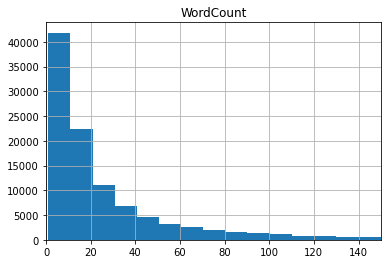

In [12]:
#What does word count distribution look like? Need visualization to decide how to bin data. Also look at descriptive statistics.
WordHist = BlendDF.hist(column = 'WordCount', bins=300)
plt.xlim([0,150])
print(BlendDF["WordCount"].describe()) #25% is 6 or less, 25% is 29 words or more, will bin accordingly

In [13]:
#Create column categorizing review word count as short (1) or not (0)
conditions = [
    (BlendDF["WordCount"] < 7),
    (BlendDF["WordCount"] > 6)
    ]
values = [1,0]
BlendDF['Short'] = np.select(conditions, values)

In [14]:
#Create column categorizing review word count as long (1) or not (0)
conditions = [
    (BlendDF["WordCount"] > 28),
    (BlendDF["WordCount"] < 29)
    ]
values = [1,0]
BlendDF['Long'] = np.select(conditions, values)

In [15]:
#Create column categorizing reviewer as verified (1) or not (0)
conditions = [
    (BlendDF['verified'] == True),
    (BlendDF['verified'] == False)
    ]
values = [1, 0]
BlendDF['Verified'] = np.select(conditions, values)

In [16]:
#Create binary column if the reviewer uploaded an image (1) or did not (0)
conditions = [
    (pd.notnull(BlendDF['image'])),
    (pd.isnull(BlendDF['image']))
    ]
values = [1, 0]
BlendDF['IsImage'] = np.select(conditions, values)

In [17]:
#Adjust vote column to allow for analysis
print(BlendDF.dtypes,'\n')
BlendDF['vote'] = BlendDF['vote'].str.replace('[^\w\s]','',regex=True) #Remove all punctuation from strings
BlendDF['vote'].replace('', '0', inplace=True) #Replace blanks with 0
BlendDF['vote'] = BlendDF['vote'].fillna('0') # Replace na values with 0
BlendDF['vote'] = BlendDF['vote'].astype({'vote': 'int32'})
print(BlendDF.dtypes,'\n')

index                      int64
overall                    int64
vote                      object
verified                    bool
reviewTime                object
reviewerID                object
asin                      object
reviewerName              object
reviewText                object
summary                   object
unixReviewTime             int64
style                     object
image                     object
Date              datetime64[ns]
BinaryRating               int32
ReviewNoFiller            object
ReviewToken               object
ReviewLemma               object
VaderCompound            float64
WordCount                  int64
Short                      int32
Long                       int32
Verified                   int32
IsImage                    int32
dtype: object 

index                      int64
overall                    int64
vote                       int32
verified                    bool
reviewTime                object
reviewerID                o

In [18]:
#Read into five emotions lexicon, convert into five dictionaries
WarrinerWords = pd.read_csv("Warriner_BE.txt", sep='\t')
JoyDict = dict(zip(WarrinerWords.Word, WarrinerWords.Joy))
AngerDict = dict(zip(WarrinerWords.Word, WarrinerWords.Anger))
SadnessDict = dict(zip(WarrinerWords.Word, WarrinerWords.Sadness))
FearDict = dict(zip(WarrinerWords.Word, WarrinerWords.Fear))
DisgustDict = dict(zip(WarrinerWords.Word, WarrinerWords.Disgust))

In [19]:
#Create columns for five emotions, initialize all of them at zero
BlendDF['Joy'] = 0.0
BlendDF['Anger'] = 0.0
BlendDF['Sadness'] = 0.0
BlendDF['Fear'] = 0.0
BlendDF['Disgust'] = 0.0

In [20]:
#Iterate through all lists of words, assigning them scores for all emotions
for index, row in BlendDF.iterrows():
    for word in row['ReviewToken']:
        BlendDF.at[index,'Joy'] += JoyDict.get(word,0)
        BlendDF.at[index,'Anger'] += AngerDict.get(word,0)
        BlendDF.at[index,'Sadness'] += SadnessDict.get(word,0)
        BlendDF.at[index,'Fear'] += FearDict.get(word,0)
        BlendDF.at[index,'Disgust'] += DisgustDict.get(word,0)

In [21]:
#Create data frame for analysis
BlendDF = BlendDF[['ReviewLemma','VaderCompound','Short','Verified','Long','IsImage','WordCount','vote','Joy','Anger','Sadness','Fear','Disgust','overall','BinaryRating']]

#Print some of the dataframe to verify work
pd.set_option('display.max_columns', None) #So as not to truncate output
pd.set_option('display.max_rows', None) #So as not to truncate output
for col in BlendDF.columns: #Print column names
    print(col)
print(BlendDF.head()) # Print first five entries in dataframe
print("The number of rows in the data frame is:", len(BlendDF.index))

ReviewLemma
VaderCompound
Short
Verified
Long
IsImage
WordCount
vote
Joy
Anger
Sadness
Fear
Disgust
overall
BinaryRating
                                         ReviewLemma  VaderCompound  Short  \
0  tiny tube much money smelled good 6 time able ...       3.880888      0   
1  hand one best entry series first time since ru...       4.880188      0   
2                                      great product       4.249925      1   
3                                         great game       4.249925      1   
4  good product good consistency fast shipping se...       4.452945      0   

   Verified  Long  IsImage  WordCount  vote      Joy    Anger  Sadness  \
0         0     0        0         11     2  19.0114   9.2388   9.1739   
1         1     0        0         28     0  50.9765  24.3794  23.8156   
2         1     0        0          2     0   5.6550   2.4657   2.5097   
3         1     0        0          2     0   7.2150   2.5111   2.6126   
4         1     0        0          7   

In [22]:
# Write final dataframe into csv
BlendDF.to_csv(r'BlendedReviews.csv', index = False)

In [23]:
"""
TF-IDF Approach
"""

#Implement TF-IDF for binary model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['BinaryRating']
X.shape, Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Implement Linear SVC model for binary TF-IDF
#89.55% Accuracy for 10% of data, 89.09% for 25% of data
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Binary Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement TF-IDF for multiclass model
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,7), analyzer='char')
X = tfidf.fit_transform(BlendDF['ReviewLemma'])
Y = BlendDF['overall']
X.shape, Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Implement Linear SVC model for TF-IDF multiclass
#63.98% Accuracy for 10% of data, 64.98% for 25% of data
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(X_train, Y_train)
LSVCScore = round((LSVC.score(X_test, Y_test))*100,2)
print('Multiclass Linear SVC Model Score for TFIDF is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Binary Linear SVC Model Score for TFIDF is: 89.32 % 

              precision    recall  f1-score   support

           0       0.57      0.65      0.61      2716
           1       0.95      0.93      0.94     18689

    accuracy                           0.89     21405
   macro avg       0.76      0.79      0.77     21405
weighted avg       0.90      0.89      0.90     21405
 

Multiclass Linear SVC Model Score for TFIDF is: 64.1 % 

              precision    recall  f1-score   support

           1       0.50      0.53      0.52      1615
           2       0.22      0.20      0.21      1101
           3       0.28      0.30      0.29      1842
           4       0.32      0.33      0.32      3264
           5       0.82      0.81      0.82     13583

    accuracy                           0.64     21405
   macro avg       0.43      0.43      0.43     21405
weighted avg       0.64      0.64      0.64     21405
 



In [24]:
"""
Doc2Vec Approach
First group of models are binary models predicting positive or negative rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['BinaryRating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Function to label reviews train or test
def label_reviews(review, label_type):
    labeled = []
    for i,v in enumerate(review):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build BOW Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Create function to vectorize all reviews
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run binary logistic regression
LR = linear_model.LogisticRegression()
LR = LR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
#90.16% Accuracy
LRScore = round((LR.score(test_vectors_dbow, Y_test))*100,2)
print('Binary Logistic Model Score for Doc2Vec:',LRScore,'%','\n')
Y_pred = LR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for binary Doc2Vec
#82.7% Accuracy
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(train_vectors_dbow, Y_train)
LSVCScore = round((LSVC.score(test_vectors_dbow, Y_test))*100,2)
print('Binary Linear SVC Model Score for Doc2Vec is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')


C:\Users\18643\AppData\Local\Temp/ipykernel_17660/1973115851.py:38: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Binary Logistic Model Score for Doc2Vec: 90.16 % 

              precision    recall  f1-score   support

           0       0.68      0.42      0.52      2716
           1       0.92      0.97      0.95     18689

    accuracy                           0.90     21405
   macro avg       0.80      0.70      0.73     21405
weighted avg       0.89      0.90      0.89     21405
 

Binary Linear SVC Model Score for Doc2Vec is: 82.7 % 

              precision    recall  f1-score   support

           0       0.41      0.79      0.54      2716
           1       0.97      0.83      0.89     18689

    accuracy                           0.83     21405
   macro avg       0.69      0.81      0.72     21405
weighted avg       0.89      0.83      0.85     21405
 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [25]:
"""
Doc2Vec Approach
Second group of models are multiclass models for 1-5 rating
"""

#Split into 80/20 train and test 
X = BlendDF['ReviewLemma']
Y = BlendDF['overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Label training and test sets using function
X_train = label_reviews(X_train, 'Train')
X_test = label_reviews(X_test,'Test')
AllData = X_train + X_test

#Build Doc2Vec model
DBOWModel = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
DBOWModel.build_vocab([x for x in AllData])

#Iterate over data to train model
for epoch in range(30):
    DBOWModel.train(utils.shuffle([x for x in AllData]), total_examples=len(AllData), epochs=1)
    DBOWModel.alpha -= 0.002
    DBOWModel.min_alpha = DBOWModel.alpha

#Vectorize training and testing data
train_vectors_dbow = get_vectors(DBOWModel, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(DBOWModel, len(X_test), 300, 'Test')

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(train_vectors_dbow, Y_train)

#Look at ability of model to predict test set
#68.54% Accuracy
MLRScore = round((MLR.score(test_vectors_dbow, Y_test))*100,2)
print('Multinomial Logistic Model Score for Doc2Vec: ',MLRScore,'%','\n')
Y_pred = MLR.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Implement Linear SVC model for multiclass Doc2Vec
#65.91% Accuracy
LSVC = LinearSVC(C = 10, class_weight='balanced', max_iter=10000)
LSVC.fit(train_vectors_dbow, Y_train)
LSVCScore = round((LSVC.score(test_vectors_dbow, Y_test))*100,2)
print('Multiclass Linear SVC Model Score for Doc2Vec is:',LSVCScore,'%', '\n')
Y_pred = LSVC.predict(test_vectors_dbow)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')


C:\Users\18643\AppData\Local\Temp/ipykernel_17660/1973115851.py:38: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


Multinomial Logistic Model Score for Doc2Vec:  68.54 % 

              precision    recall  f1-score   support

           1       0.53      0.51      0.52      1615
           2       0.29      0.09      0.13      1101
           3       0.36      0.20      0.25      1842
           4       0.44      0.20      0.28      3264
           5       0.75      0.94      0.83     13583

    accuracy                           0.69     21405
   macro avg       0.47      0.39      0.40     21405
weighted avg       0.63      0.69      0.64     21405
 

Multiclass Linear SVC Model Score for Doc2Vec is: 65.91 % 

              precision    recall  f1-score   support

           1       0.43      0.65      0.52      1615
           2       0.21      0.17      0.19      1101
           3       0.30      0.28      0.29      1842
           4       0.39      0.24      0.30      3264
           5       0.81      0.85      0.83     13583

    accuracy                           0.66     21405
   macro avg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [26]:
"""
VADER Score and other variables approach
First group of models are binary models predicting positive or negative rating
"""

#Split data into training and test sets with a 80/20 split for all binary models
#Based on the very low coefficients for both WordCount and vote, these variables were left out of the models.
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run binary logistic regression
LR = linear_model.LogisticRegression()
LR.fit(X_train, Y_train)
print('Binary Logistic Intercept is:', LR.intercept_, '\n')
print('Binary Logistic Coefficients are:', LR.coef_, '\n')

#Look at ability of model to predict test set
#87.97% Accuracy for 10% of data, 88.14% for 25% of data
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for VADER Score and other variables:',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Binary SVM
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
#87.67% Accuracy for 10% of data, 87.6% for 25% of data
SVMScore = round((svclassifier.score(X_test, Y_test))*100,2)
print('Binary SVM Score for VADER Score and other variables:',SVMScore,'%','\n')
Y_pred = svclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
#87.28% Accuracy with 10% of data, 87.54% with 25% of data
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Binary Naive Bayes Classifier Score for VADER Score and other variables:',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')


Binary Logistic Intercept is: [-2.25425174] 

Binary Logistic Coefficients are: [[ 1.0505155   0.69373129  0.20574623 -0.18606265 -0.91405258]] 

Binary Logistic Model Score for VADER Score and other variables: 87.52 % 

              precision    recall  f1-score   support

           0       0.52      0.25      0.33      2716
           1       0.90      0.97      0.93     18689

    accuracy                           0.88     21405
   macro avg       0.71      0.61      0.63     21405
weighted avg       0.85      0.88      0.86     21405
 

Binary SVM Score for VADER Score and other variables: 87.31 % 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2716
           1       0.87      1.00      0.93     18689

    accuracy                           0.87     21405
   macro avg       0.44      0.50      0.47     21405
weighted avg       0.76      0.87      0.81     21405
 

Binary Naive Bayes Classifier Score for VADER Score and o

In [27]:
"""
VADER Score and other variables approach
Second group of models are multiclass models for 1-5 rating
"""
#Split data into training and test sets with a 80/20 split for multiclass models
X = BlendDF[['VaderCompound','Short','Verified','Long','IsImage']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
#64.86% Accuracy with 10% of data, 65.04% with 25% of data
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for VADER Score and other variables: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Multiclass SVM
msvclassifier = SVC(kernel='linear')
msvclassifier.fit(X_train, Y_train)

#Look at ability of model to predict test set
#64.79% Accuracy with 10% of data, 64.97% with 25% of data
MSVMScore = round((msvclassifier.score(X_test, Y_test))*100,2)
print('Multiclass SVM Score is for VADER Score and other variables: ',MSVMScore,'%','\n')
Y_pred = msvclassifier.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
#63.37% Accuracy with 10% of data, 63.23% with 25% of data
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for VADER Score and other variables: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
#60.43% Accuracy with 10% of data, 62.73% with 25% of data
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for VADER Score and other variables: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for VADER Score and other variables:  64.57 % 

              precision    recall  f1-score   support

           1       0.33      0.38      0.35      1615
           2       0.00      0.00      0.00      1101
           3       0.17      0.01      0.01      1842
           4       0.15      0.00      0.01      3264
           5       0.68      0.97      0.80     13583

    accuracy                           0.65     21405
   macro avg       0.27      0.27      0.23     21405
weighted avg       0.49      0.65      0.54     21405
 

Multiclass SVM Score is for VADER Score and other variables:  64.66 % 

              precision    recall  f1-score   support

           1       0.34      0.35      0.34      1615
           2       0.00      0.00      0.00      1101
           3       0.00      0.00      0.00      1842
           4       0.00      0.00      0.00      3264
           5       0.67      0.98      0.80     13583

    accuracy                  

In [28]:
"""
Five Emotions Approach
First group of models are binary models predicting positive or negative rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for all binary models
#Based on the very low coefficients for both WordCount and vote, these variables were left out of the models.
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust']] #set independent variables for regression
Y = BlendDF['BinaryRating'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, Y_train)

#Look at ability of model to predict test set
#87.67% Accuracy with 10% of data, 87.6% with 25% of data
NBScore = round((NB.score(X_test, Y_test))*100,2)
print('Naive Bayes Classifier Score is for Five Emotions Model: ',NBScore,'%','\n')
Y_pred = NB.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run binary logistic regression
LR = linear_model.LogisticRegression()
LR.fit(X_train, Y_train)

#Look at ability of model to predict test set
#87.45 % Accuracy with 10% of data, 87.38% with 25% of data
LRScore = round((LR.score(X_test, Y_test))*100,2)
print('Binary Logistic Model Score for Five Emotions Model: ',LRScore,'%','\n')
Y_pred = LR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Naive Bayes Classifier Score is for Five Emotions Model:  87.31 % 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2716
           1       0.87      1.00      0.93     18689

    accuracy                           0.87     21405
   macro avg       0.44      0.50      0.47     21405
weighted avg       0.76      0.87      0.81     21405
 

Binary Logistic Model Score for Five Emotions Model:  87.05 % 

              precision    recall  f1-score   support

           0       0.33      0.02      0.04      2716
           1       0.87      0.99      0.93     18689

    accuracy                           0.87     21405
   macro avg       0.60      0.51      0.48     21405
weighted avg       0.81      0.87      0.82     21405
 



In [29]:
"""
Five Emotions Approach
Second group of models are multiclass models for 1-5 rating
SVM Models have been excluded due to high number of continuous variables makes processing power/time overwhelming
"""

#Split data into training and test sets with a 80/20 split for multiclass models
X = BlendDF[['Joy','Anger','Sadness','Fear','Disgust']] #set independent variables for regression
Y = BlendDF['overall'] #set dependent variable for regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #Split into 80/20 train and test sets

#Run multinomial logistic regression
MLR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
MLR.fit(X_train, Y_train)

#Look at ability of model to predict test set
#63.62% Accuracy with 10% of data, 63.56% with 25% of data
MLRScore = round((MLR.score(X_test, Y_test))*100,2)
print('Multinomial Logistic Model Score for Five Emotions Model: ',MLRScore,'%','\n')
Y_pred = MLR.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run K Nearest Neighbors Algorithm
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train, Y_train)

#Look at ability of model to predict test set
#62.55% Accuracy with 10% of data, 62.21% with 25% of data
KNNScore = round((KNN.score(X_test, Y_test))*100,2)
print('K Nearest Neighbors Algorithm Model Score for Five Emotions Model: ',KNNScore,'%','\n')
Y_pred = KNN.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

#Run Random Forest Algorithm
RF = RandomForestClassifier(n_estimators=5, random_state=0)
RF.fit(X_train, Y_train)

#Look at ability of model to predict test set
#55.39% Accuracy with 10% of data, 56.14% with 25% of data
RFScore = round((RF.score(X_test, Y_test))*100,2)
print('Random Forest Classifier Model Score for Five Emotions Model: ',RFScore,'%','\n')
Y_pred = RF.predict(X_test)
print(classification_report(Y_test, Y_pred, zero_division=0), '\n')

Multinomial Logistic Model Score for Five Emotions Model:  63.37 % 

              precision    recall  f1-score   support

           1       0.23      0.04      0.06      1615
           2       0.17      0.00      0.00      1101
           3       0.24      0.01      0.02      1842
           4       0.35      0.03      0.05      3264
           5       0.64      0.99      0.78     13583

    accuracy                           0.63     21405
   macro avg       0.33      0.21      0.18     21405
weighted avg       0.51      0.63      0.51     21405
 

K Nearest Neighbors Algorithm Model Score for Five Emotions Model:  61.98 % 

              precision    recall  f1-score   support

           1       0.29      0.15      0.20      1615
           2       0.13      0.02      0.03      1101
           3       0.13      0.02      0.04      1842
           4       0.27      0.08      0.12      3264
           5       0.66      0.94      0.78     13583

    accuracy                        

In [30]:
"""
Print out run times to decide how big of a data set to use
Code run times: 25 minutes 13 seconds for 10% of data; 2 hours 58 minutes 5 seconds for 25% of data
"""

ElapsedSeconds = time.time() - StartTime
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)
print(convert(ElapsedSeconds))

1:59:42
